In [ ]:
#import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.5/644.5 kB 9.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [ ]:
%cd /mydrive/Yolo_Nas/pothole
#/mydrive/YOLOv8

/content/gdrive/My Drive/Yolo_Nas/pothole


In [ ]:
os.makedirs('datasets', exist_ok=True)

In [ ]:
%cd datasets

/content/gdrive/MyDrive/YOLOv8/datasets


In [ ]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)

download_file(
    'https://www.dropbox.com/s/qvglw8pqo16769f/pothole_dataset_v8.zip?dl=1',
    'pothole_dataset_v8.zip'
)

In [ ]:
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('pothole_dataset_v8.zip')

Extracted all


In [ ]:
%cd ..

/content/gdrive/MyDrive/YOLOv8


In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize a few training images.
plot(
    image_paths='pothole/train/images/',
    label_paths='pothole/train/labels/',
    num_samples=4,
)

In [ ]:
%%writefile pothole_v8.yaml
path: 'pothole_dataset_v8/'
train: 'train/images'
val: 'valid/images'

# class names
names:
  0: 'pothole'

Writing pothole_v8.yaml


In [ ]:
# Sample training for 5 epoch.
EPOCHS = 5
!yolo task=detect mode=train model=yolov8n.pt imgsz=1280 data=pothole_v8.yaml epochs={EPOCHS} batch=8 name=yolov8n_v8_50e

100% 6.23M/6.23M [00:00<00:00, 155MB/s]
Ultralytics YOLOv8.0.199 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=pothole_v8.yaml, epochs=5, patience=50, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v8_50e, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, 

In [ ]:
!yolo task=detect mode=val model=runs/detect/yolov8n_v8_50e/weights/best.pt name=yolov8n_eval data=pothole_v8.yaml

Ultralytics YOLOv8.0.199 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/gdrive/MyDrive/YOLOv8/datasets/pothole_dataset_v8/valid/labels.cache... 271 images, 0 backgrounds, 0 corrupt: 100% 271/271 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/gdrive/MyDrive/YOLOv8/datasets/pothole_dataset_v8/valid/images/G0011603.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/gdrive/MyDrive/YOLOv8/datasets/pothole_dataset_v8/valid/images/G0011614.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/gdrive/MyDrive/YOLOv8/datasets/pothole_dataset_v8/valid/images/G0011616.jpg: 2 duplicate labels removed
val: WARNING ⚠️ /content/gdrive/MyDrive/YOLOv8/datasets/pothole_dataset_v8/valid/images/G0011661.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/gdrive/MyDrive/YOLOv8/datasets/pothole_dataset_v8/valid/images/G0011662.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/

In [ ]:
!yolo task=detect \
mode=predict \
model=runs/detect/yolov8n_v8_50e/weights/best.pt \
source=datasets/pothole_dataset_v8/valid/images \
imgsz=1280 \
name=yolov8n_v8_50e_infer1280 \
hide_labels=True

WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'show_labels' instead.
Ultralytics YOLOv8.0.199 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

image 1/271 /content/gdrive/MyDrive/YOLOv8/datasets/pothole_dataset_v8/valid/images/G0011195.jpg: 736x1280 1 pothole, 105.9ms
image 2/271 /content/gdrive/MyDrive/YOLOv8/datasets/pothole_dataset_v8/valid/images/G0011196.jpg: 736x1280 2 potholes, 12.3ms
image 3/271 /content/gdrive/MyDrive/YOLOv8/datasets/pothole_dataset_v8/valid/images/G0011242.jpg: 736x1280 (no detections), 12.4ms
image 4/271 /content/gdrive/MyDrive/YOLOv8/datasets/pothole_dataset_v8/valid/images/G0011243.jpg: 736x1280 3 potholes, 12.3ms
image 5/271 /content/gdrive/MyDrive/YOLOv8/datasets/pothole_dataset_v8/valid/images/G0011244.jpg: 736x1280 1 pothole, 17.4ms
image 6/271 /content/gdrive/MyDrive/YOLOv8/datasets/pothole_dataset_v

In [ ]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

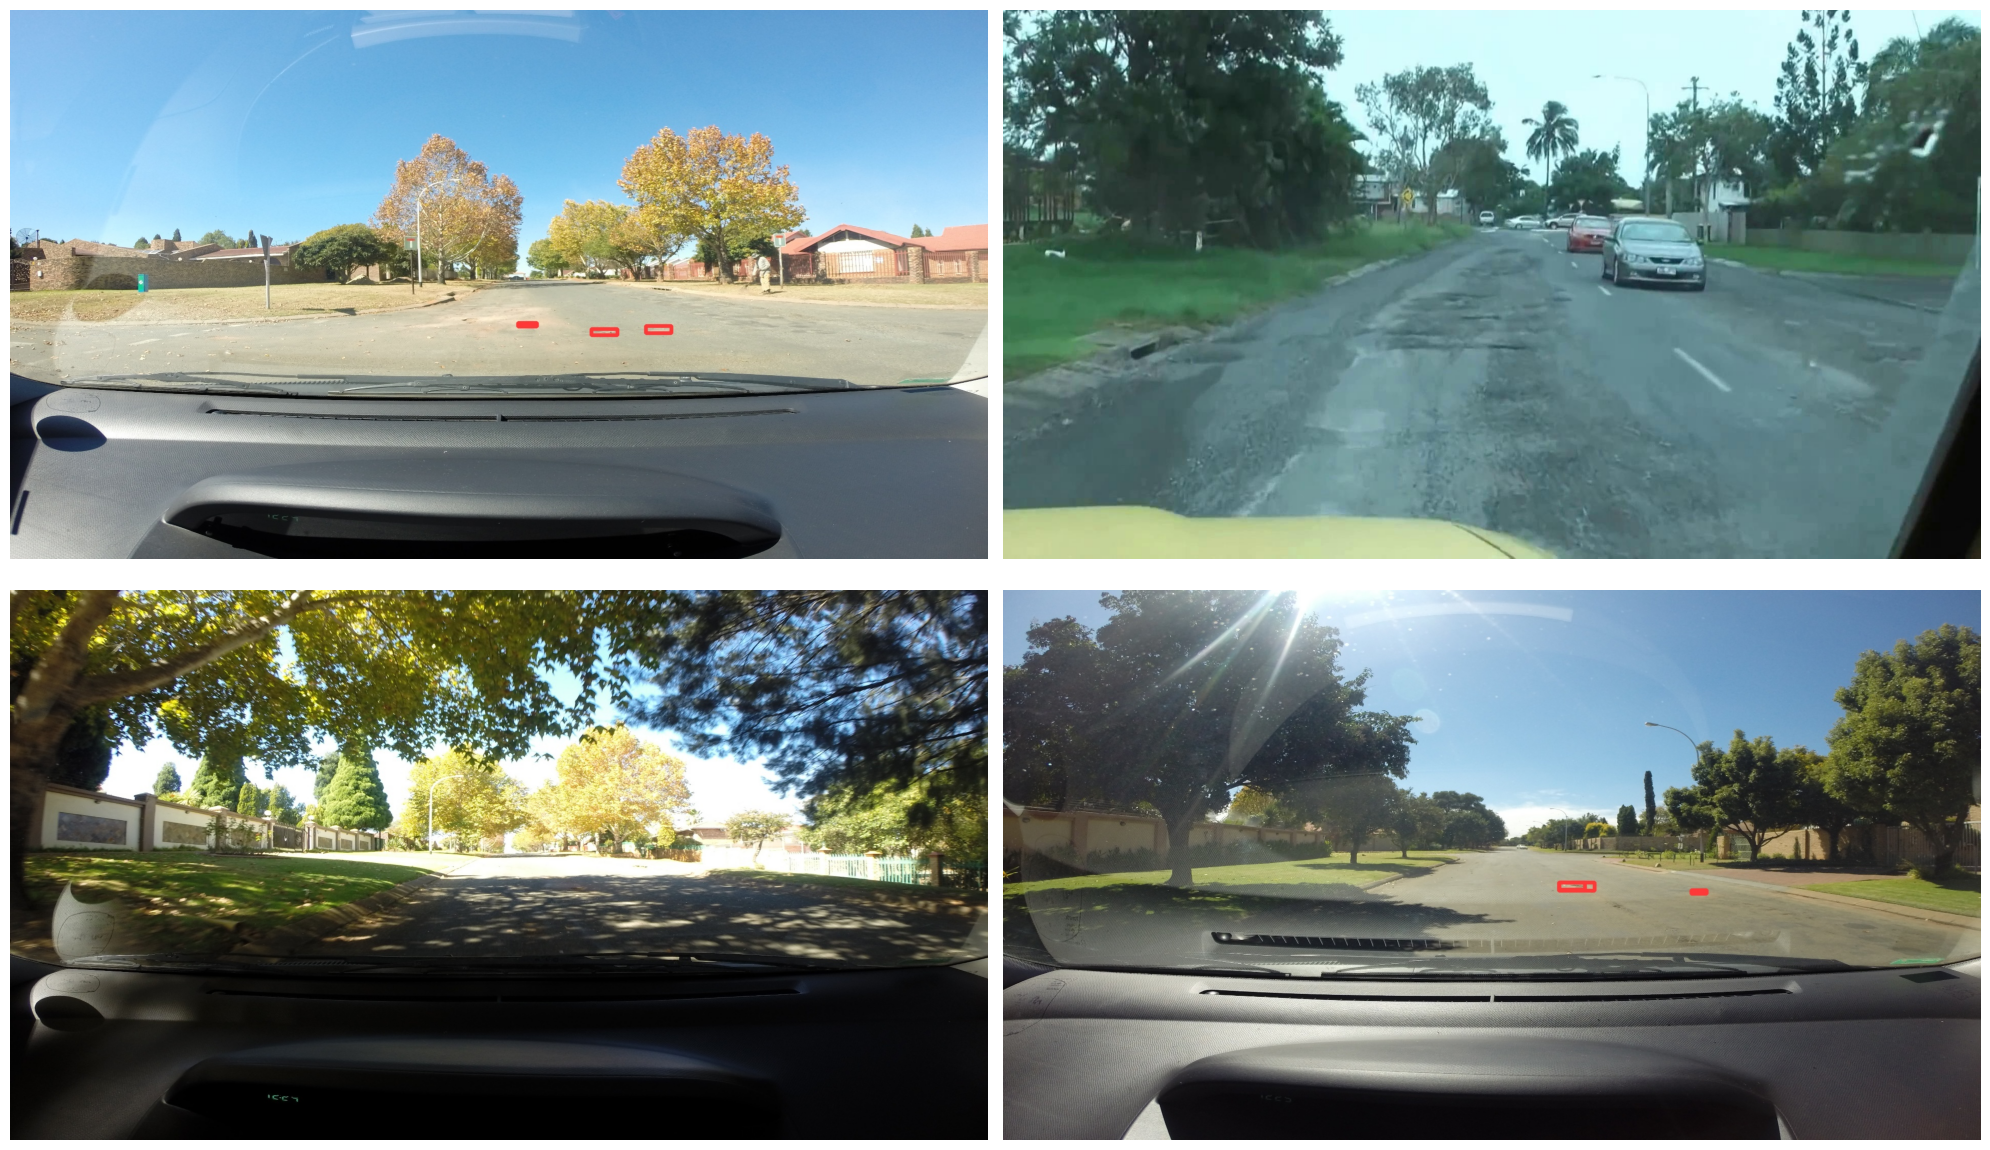

In [ ]:
visualize('runs/detect/yolov8n_v8_50e_infer1280/')